##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 기본 훈련 루프

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/basic_training_loops" class=""><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/basic_training_loops.ipynb" class="">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">    GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이전 가이드에서 [텐서](./tensor.ipynb), [변수](./variable.ipynb), [그래디언트 테이프](autodiff.ipynb) , [모듈](./intro_to_modules.ipynb)에 관해 배웠습니다. 이 가이드에서는 모델을 훈련하기 위해 이들 요소를 모두 맞춤 조정합니다.

TensorFlow에는 상용구를 줄이기 위해 유용한 추상화를 제공하는 상위 수준의 신경망 API인 [tf.Keras API](https://www.tensorflow.org/guide/keras/overview)도 포함되어 있습니다. 그러나 이 가이드에서는 기본 클래스를 사용합니다.

## 설정

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

2022-12-14 21:14:34.737656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:14:34.737744: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:14:34.737753: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 머신러닝 문제 해결하기

머신러닝 문제의 해결은 일반적으로 다음 단계로 구성됩니다.

- 훈련 데이터를 얻습니다.
- 모델을 정의합니다.
- 손실 함수를 정의합니다.
- 훈련 데이터를 실행하여 이상적인 값에서 손실을 계산합니다.
- 손실에 대한 기울기를 계산하고 *최적화 프로그램* 를 사용하여 데이터에 맞게 변수를 조정합니다.
- 결과를 평가합니다.

설명을 위해 이 가이드에서는 $W$(가중치) 및 $b$(바이어스)의 두 가지 변수가 있는 간단한 선형 모델 $f(x) = x * W + b$를 개발합니다.

이것이 가장 기본적인 머신러닝 문제입니다. $x$와 $y$가 주어지면 [간단한 선형 회귀](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression)를 통해 선의 기울기와 오프셋을 찾습니다.

## 데이터

지도 학습은 *입력*(일반적으로 *x*로 표시됨)과 *출력*(*y*로 표시, 종종 *레이블*이라고 함)을 사용합니다. 목표는 입력에서 출력 값을 예측할 수 있도록 쌍을 이룬 입력과 출력에서 학습하는 것입니다.

TensorFlow에서 데이터의 각 입력은 거의 항상 텐서로 표현되며, 종종 벡터입니다. 지도 학습에서 출력(또는 예측하려는 값)도 텐서입니다.

다음은 선을 따라 점에 가우시안 (정규 분포) 노이즈를 추가하여 합성된 데이터입니다.

In [3]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

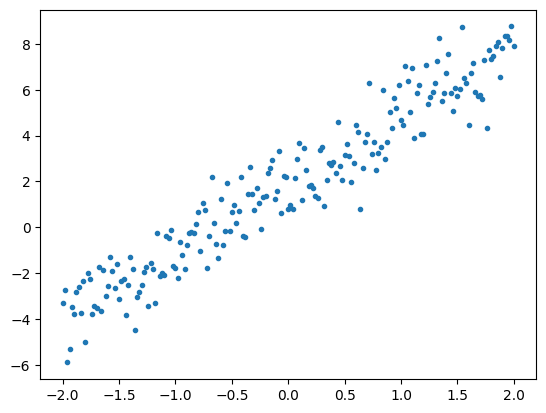

In [4]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

텐서는 일반적으로 *배치* 또는 입력과 출력이 함께 쌓인 그룹의 형태로 수집됩니다. 일괄 처리는 몇 가지 훈련 이점을 제공할 수 있으며 가속기 및 벡터화된 계산에서 잘 동작합니다. 데이터세트가 얼마나 작은지를 고려할 때 전체 데이터세트를 단일 배치로 처리할 수 있습니다.

## 모델 정의하기

`tf.Variable`을 사용하여 모델의 모든 가중치를 나타냅니다. `tf.Variable`은 값을 저장하고 필요에 따라 텐서 형식으로 제공합니다. 자세한 내용은 [변수 가이드](./variable.ipynb)를 참조하세요.

`tf.Module`을 사용하여 변수와 계산을 캡슐화합니다. 모든 Python 객체를 사용할 수 있지만 이렇게 하면 쉽게 저장할 수 있습니다.

여기서 *w*와 *b*를 모두 변수로 정의합니다.

In [5]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


초기 변수는 여기에서 고정된 방식으로 설정되지만 Keras에는 나머지 Keras의 유무에 관계없이 사용할 수 있는 여러 [초기화 프로그램](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)이 함께 제공됩니다.

### 손실 함수 정의하기

손실 함수는 주어진 입력에 대한 모델의 출력이 목표 출력과 얼마나 잘 일치하는지 측정합니다. 목표는 훈련 중에 이러한 차이를 최소화하는 것입니다. "평균 제곱" 오류라고도 하는 표준 L2 손실을 정의합니다.

In [6]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

모델을 훈련하기 전에 모델의 예측을 빨간색으로, 훈련 데이터를 파란색으로 플롯하여 손실값을 시각화할 수 있습니다.

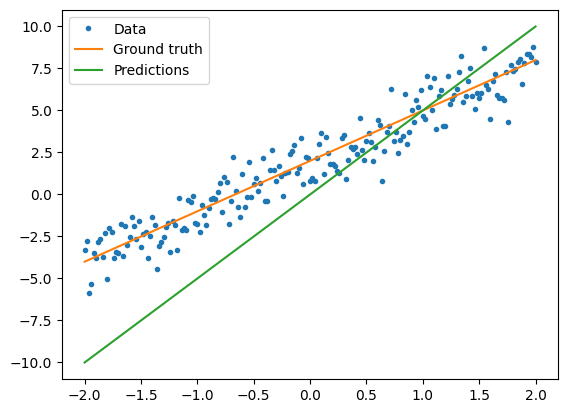

Current loss: 10.288067


In [7]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

### 훈련 루프 정의하기

훈련 루프는 순서대로 3가지 작업을 반복적으로 수행하는 것으로 구성됩니다.

- 모델을 통해 입력 배치를 전송하여 출력 생성
- 출력을 출력(또는 레이블)과 비교하여 손실 계산
- 그래디언트 테이프를 사용하여 그래디언트 찾기
- 해당 그래디언트로 변수 최적화

이 예제에서는 [경사 하강법](https://en.wikipedia.org/wiki/Gradient_descent)을 사용하여 모델을 훈련할 수 있습니다.

`tf.keras.optimizers`에서 캡처되는 경사 하강법 체계에는 다양한 변형이 있습니다. 하지만 첫 번째 원칙을 준수하는 의미에서, 기본적인 수학을 직접 구현할 것입니다. 자동 미분을 위한 `tf.GradientTape` 및 값 감소를 위한 `tf.assign_sub`(`tf.assign`과 `tf.sub`를 결합하는 값)의 도움을 받습니다.

In [8]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

훈련을 살펴보려면 훈련 루프를 통해 *x* 및 *y*의 같은 배치를 보내고 `W` 및 `b`가 발전하는 모양을 확인합니다.

In [9]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"


def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    weights.append(model.w.numpy())
    biases.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))

훈련 수행

In [10]:
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=10.28807


Epoch  0:
     W = 4.45, b = 0.38, loss=6.35338
Epoch  1:
     W = 4.04, b = 0.68, loss=4.11694
Epoch  2:
     W = 3.75, b = 0.92, loss=2.83603
Epoch  3:
     W = 3.53, b = 1.11, loss=2.09655
Epoch  4:
     W = 3.37, b = 1.27, loss=1.66616
Epoch  5:
     W = 3.26, b = 1.39, loss=1.41360
Epoch  6:
     W = 3.17, b = 1.49, loss=1.26418
Epoch  7:
     W = 3.11, b = 1.57, loss=1.17507
Epoch  8:
     W = 3.07, b = 1.63, loss=1.12153
Epoch  9:
     W = 3.03, b = 1.68, loss=1.08912


시간이 지남에 따른 가중치의 전개 양상을 표시:

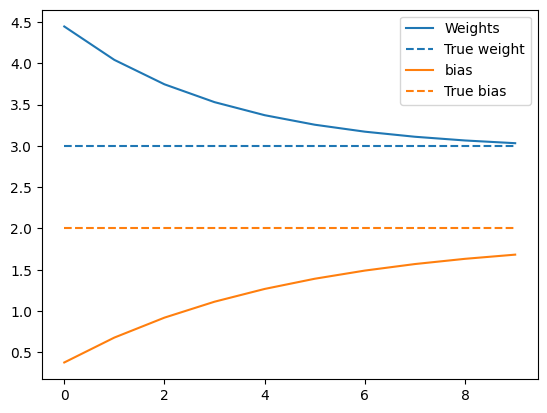

In [11]:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

훈련된 모델 성능 시각화

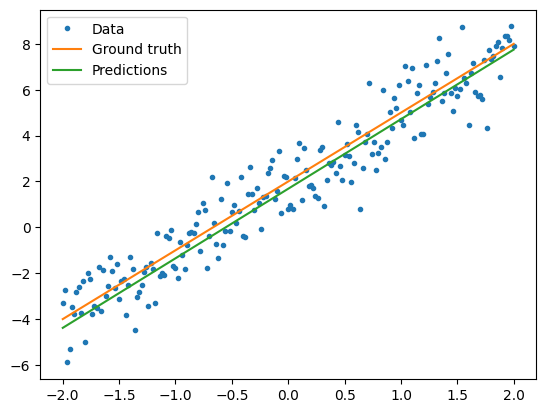

Current loss: 1.089116


In [12]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

## 같은 솔루션이지만, Keras를 사용한 경우

위의 코드를 Keras의 해당 코드와 대조해 보면 유용합니다.

`tf.keras.Model`을 하위 클래스화하면 모델 정의는 정확히 같게 보입니다. Keras 모델은 궁극적으로 모듈에서 상속한다는 것을 기억하세요.

In [13]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0:
     W = 4.45, b = 0.38, loss=6.35338
Epoch  1:
     W = 4.04, b = 0.68, loss=4.11694
Epoch  2:
     W = 3.75, b = 0.92, loss=2.83603
Epoch  3:
     W = 3.53, b = 1.11, loss=2.09655
Epoch  4:
     W = 3.37, b = 1.27, loss=1.66616
Epoch  5:
     W = 3.26, b = 1.39, loss=1.41360
Epoch  6:
     W = 3.17, b = 1.49, loss=1.26418
Epoch  7:
     W = 3.11, b = 1.57, loss=1.17507
Epoch  8:
     W = 3.07, b = 1.63, loss=1.12153
Epoch  9:
     W = 3.03, b = 1.68, loss=1.08912


모델을 생성할 때마다 새로운 훈련 루프를 작성하는 대신 Keras의 내장 기능을 바로 가기로 사용할 수 있습니다. Python 훈련 루프를 작성하거나 디버그하지 않으려는 경우 유용할 수 있습니다.

그렇게 하려면, `model.compile()`을 사용하여 매개변수를 설정하고 `model.fit()`을 사용하여 훈련해야 합니다. L2 손실 및 경사 하강법의 Keras 구현을 바로 가기로 사용하면 코드가 적을 수 있습니다. Keras 손실 및 최적화 프록그램은 이러한 편의성 함수 외부에서 사용할 수 있으며 이전 예제에서 사용할 수 있습니다.

In [14]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

Keras `fit` 배치 데이터 또는 전체 데이터세트를 NumPy 배열로 예상합니다. NumPy 배열은 배치로 분할되며, 기본 배치 크기는 32입니다.

이 경우 손으로 쓴 루프의 동작과 일치시키려면 `x`를 크기 1000의 단일 배치로 전달해야 합니다.

In [15]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10


1/1 [==============================] - ETA: 0s - loss: 10.2881

1/1 [==============================] - 0s 366ms/step - loss: 10.2881


Epoch 2/10


1/1 [==============================] - ETA: 0s - loss: 6.3534

1/1 [==============================] - 0s 5ms/step - loss: 6.3534


Epoch 3/10


1/1 [==============================] - ETA: 0s - loss: 4.1169

1/1 [==============================] - 0s 4ms/step - loss: 4.1169


Epoch 4/10


1/1 [==============================] - ETA: 0s - loss: 2.8360

1/1 [==============================] - 0s 4ms/step - loss: 2.8360


Epoch 5/10


1/1 [==============================] - ETA: 0s - loss: 2.0966

1/1 [==============================] - 0s 4ms/step - loss: 2.0966


Epoch 6/10


1/1 [==============================] - ETA: 0s - loss: 1.6662

1/1 [==============================] - 0s 4ms/step - loss: 1.6662


Epoch 7/10


1/1 [==============================] - ETA: 0s - loss: 1.4136

1/1 [==============================] - 0s 4ms/step - loss: 1.4136


Epoch 8/10


1/1 [==============================] - ETA: 0s - loss: 1.2642

1/1 [==============================] - 0s 4ms/step - loss: 1.2642


Epoch 9/10


1/1 [==============================] - ETA: 0s - loss: 1.1751

1/1 [==============================] - 0s 4ms/step - loss: 1.1751


Epoch 10/10


1/1 [==============================] - ETA: 0s - loss: 1.1215

1/1 [==============================] - 0s 4ms/step - loss: 1.1215


Keras는 훈련 전이 아닌 훈련 후 손실을 출력하므로 첫 번째 손실이 더 낮게 나타나지만, 그렇지 않으면 본질적으로 같은 훈련 성능을 보여줍니다.

## 다음 단계

이 가이드에서는 텐서, 변수, 모듈 및 그래디언트 테이프의 핵심 클래스를 사용하여 모델을 빌드하고 훈련하는 방법과 이러한 아이디어가 Keras에 매핑되는 방법을 살펴보았습니다.

그러나 이것은 매우 단순한 문제입니다. 보다 실용적인 소개는 [사용자 정의 훈련 연습](../tutorials/customization/custom_training_walkthrough.ipynb)을 참조하세요.

내장 Keras 훈련 루프의 사용에 관한 자세한 내용은 [이 가이드](https://www.tensorflow.org/guide/keras/train_and_evaluate)를 참조하세요. 훈련 루프 및 Keras에 관한 자세한 내용은 [이 가이드](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)를 참조하세요. 사용자 정의 분산 훈련 루프의 작성에 관해서는 [이 가이드](distributed_training.ipynb#using_tfdistributestrategy_with_basic_training_loops_loops)를 참조하세요.